# Vehicle Routing Problem
## Initialization

In [1]:
import numpy as np
import utility

from full_qubo_solver import FullQuboSolver
from average_partition_solver import AveragePartitionSolver
from qiskit_native_solver import QiskitNativeSolver
from route_activation_solver import RouteActivationSolver
from clustered_tsp_solver import ClusteredTspSolver
from solution_partition_solver import SolutionPartitionSolver

In [2]:
n = 5
m = 2
seed = 1543

In [3]:
instance, xc, yc = utility.generate_vrp_instance(n, seed)

In [4]:
vrp1 = FullQuboSolver(n, m, instance)
vrp2 = AveragePartitionSolver(n, m, instance)
vrp3 = RouteActivationSolver(n, m, instance)
vrp4 = QiskitNativeSolver(n, m, instance)
vrp5 = ClusteredTspSolver(n, m, instance)
vrp6 = SolutionPartitionSolver(n, m, instance)

## Solve via Hybrid Solvers

In [5]:
vrp_list = [vrp1, vrp2, vrp3, vrp4, vrp5, vrp6]
for vrp in vrp_list:
    vrp.solve(solver='leap')

## Full Qubo Solver (FQS)

***Representation***

$x_{i,j,k} = 1$ if $i^{th}$ vehicle is in $j^{th}$ node at the $k^{th}$ timestep.

$$i \in \{1, 2, \dots M\}; \; j \in \{0, 1, \dots N\}; \; k \in \{1, 2, \dots N\}$$

***Objective Function***

$$C = \sum_{m=1}^M \sum_{n=1}^N C_{0,n} x_{m,n,1} + \sum_{m=1}^M \sum_{n=1}^N C_{n,0} x_{m,n,N} + \sum_{m=1}^M \sum_{n=1}^{N-1} \sum_{i=0}^{N} \sum_{j=0}^{N} C_{i,j} x_{m,i,n} x_{m,j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node (other than the depot) is served by exactly one vehicle at exactly one time instant.

$$\sum_{i=1}^M \sum_{j=1}^N x_{i,k,j} = 1 \;\;\forall k$$

 - A vehicle can be at only one place at any given timestep.

$$\sum_{k=0}^N x_{i,k,j} = 1 \;\;\forall i, j$$

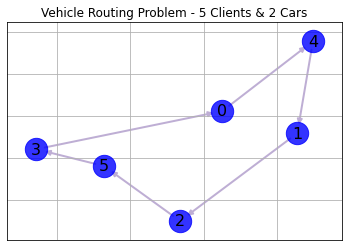

In [6]:
vrp1.visualize(xc, yc)

## Average Partitioning Solver (APS)

***Representation***

$x_{i,j,k} = 1$ if $i^{th}$ vehicle is in $j^{th}$ node at the $k^{th}$ timestep.

$$i \in \{1, 2, \dots M\}; \; j \in \{0, 1, \dots N\}; \; k \in \{1, 2, \dots T\}$$

The maximum timestep $T$ is evaluated as follows

$$T = \frac{N}{M} + L$$

Here, $L$ is a solver parameter called *Limit Radius* and naturally, we round up the above $T$ to the next integer.

***Objective Function***

$$C = \sum_{m=1}^M \sum_{n=1}^N C_{0,n} x_{m,n,1} + \sum_{m=1}^M \sum_{n=1}^N C_{n,0} x_{m,n,T} + \sum_{m=1}^M \sum_{n=1}^{T-1} \sum_{i=0}^{N} \sum_{j=0}^{N} C_{i,j} x_{m,i,n} x_{m,j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node (other than the depot) is served by exactly one vehicle at exactly one time instant.

$$\sum_{i=1}^M \sum_{j=1}^T x_{i,k,j} = 1 \;\;\forall k$$

 - A vehicle can be at only one place at any given timestep.

$$\sum_{k=0}^N x_{i,k,j} = 1 \;\;\forall i, j$$

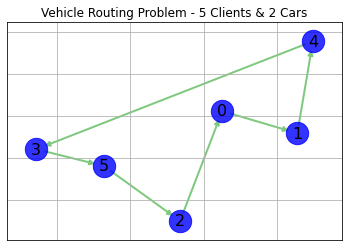

In [7]:
vrp2.visualize(xc, yc)

## Route Activation Solver (RAS)

***Representation***

$x_{i,j} = 1$ if the route from the $i^{th}$ node to the $j^{th}$ node is traversed by any vehicle at any time.

$$i \in \{0, 1, \dots N\}; \; j \in \{0, 1, \dots N\}; \; i \neq j$$

***Objective Function***

$$C = \sum_{i=0}^N \sum_{j=0}^N C_{i,j} x_{i,j}$$

***Constraints***

 - Each node (other than the depot) has exactly $1$ outgoing active edge and exactly $1$ incoming active edge.

$$\sum_{j\neq i,j=0}^N x_{i,j} = 1 \;\;\forall i$$
$$\sum_{i\neq j,i=0}^N x_{i,j} = 1 \;\;\forall j$$

 - The depot has exactly $M$ outgoing and $M$ incoming connections.

$$\sum_{j=1}^N x_{0,j} = M $$
$$\sum_{j=1}^N x_{j,0} = M $$

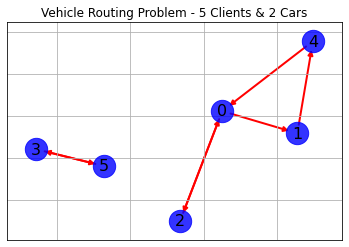

In [8]:
vrp3.visualize(xc, yc)

## Qiskit Native Solver (QNS)

***Representation***

$x_{i,j} = 1$ if the route from the $i^{th}$ node to the $j^{th}$ node is traversed by any vehicle at any time.

$$i \in \{0, 1, \dots N\}; \; j \in \{0, 1, \dots N\}; \; i \neq j$$

***Objective Function***

$$C = \sum_{i=0}^N \sum_{j=0}^N C_{i,j} x_{i,j}$$

***Constraints***

 - Each node (other than the depot) has exactly $1$ outgoing active edge and exactly $1$ incoming active edge.

$$\sum_{j\neq i,j=0}^N x_{i,j} = 1 \;\;\forall i$$
$$\sum_{i\neq j,i=0}^N x_{i,j} = 1 \;\;\forall j$$

 - The depot has exactly $M$ outgoing and $M$ incoming connections.

$$\sum_{j=1}^N x_{0,j} = M $$
$$\sum_{j=1}^N x_{j,0} = M $$

 - DFJ Constraints for subtour elimination. Basically consider every possible subtour loop and eliminate them individually. Very inefficient.

$$\sum_{i, j \in S, i \neq j} x_{i,j} \leq |S| - 1 \;\;\forall S$$

Here, $S$ represents a set of nodes excluding the depot that can form a loop and $|S|$ is the number of nodes in the loop $S$. The above constraint needs to be enforced for all possible loops $S$, which is what makes it so inefficient.

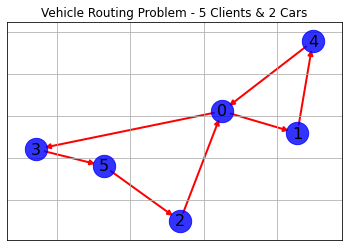

In [9]:
vrp4.visualize(xc, yc)

## Clustered Tsp Solver (CTS)

***Algorithm***

Use a multilevel maxcut with $M$ partitions to cluster the nodes into $M$ clsuters. Assign each cluster to a different vehicle and solve Travelling Salesman for each. Clustering is done using D-Wave's Leap Hybrid DQM Solvers. Below we show the formulation for TSP with $P$ nodes. This TSP is to be repeated for each cluster.

***Representation***

$x_{i,j} = 1$ if the salesman is at the $i^{th}$ node at the $j^{th}$ timestep.

$$i \in \{1, \dots P\}; \; j \in \{1, \dots P\}$$

***Objective Function***

$$C = \sum_{n=1}^P C_{0,n} x_{n,1} + \sum_{n=1}^P C_{n,0} x_{n,P} + \sum_{n=1}^{N-1} \sum_{i=1}^{N} \sum_{j=1}^{N} C_{i,j} x_{i,n} x_{j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node is served at only one time.

$$\sum_{j=1}^P x_{i,j} = 1 \;\;\forall i$$

 - The vehicle can be at only one place at a given time

$$\sum_{i=1}^P x_{i,j} = 1 \;\;\forall j$$

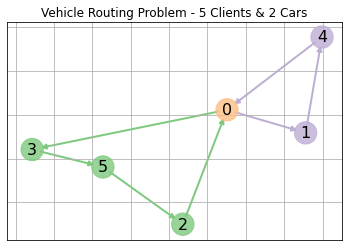

In [10]:
vrp5.visualize(xc, yc)

## Solution Partitioning Solver (SPS)

***Algorithm***

Assume a single vehicle and solve the TSP for the problem. Then cut the TSP solution at $M-1$ points to generate $M$ routes for $M$ vehicles. While selecting the cuts, out of a total possible $N-1$ choices, choose the $M-1$ cuts that would minimize the extra cost incurred. Below, we outline the TSP formulation used.

***Representation***

$x_{i,j} = 1$ if the salesman is at the $i^{th}$ node at the $j^{th}$ timestep.

$$i \in \{1, \dots P\}; \; j \in \{1, \dots P\}$$

***Objective Function***

$$C = \sum_{n=1}^P C_{0,n} x_{n,1} + \sum_{n=1}^P C_{n,0} x_{n,P} + \sum_{n=1}^{N-1} \sum_{i=1}^{N} \sum_{j=1}^{N} C_{i,j} x_{i,n} x_{j,n+1}$$

Here, the first term represents the cost of moving from the depot to the first visited client for each vehicle, the second term represents the cost of moving from the last visited client to the depot for each vehicle, and the third term represents the costs at the intermediate nodes.

***Constraints***

 - Every node is served at only one time.

$$\sum_{j=1}^P x_{i,j} = 1 \;\;\forall i$$

 - The vehicle can be at only one place at a given time

$$\sum_{i=1}^P x_{i,j} = 1 \;\;\forall j$$

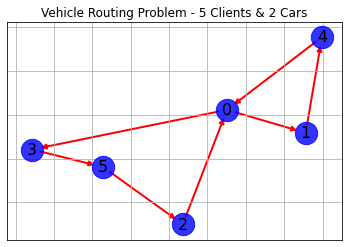

In [11]:
vrp6.visualize(xc, yc)

## Cost Comparison

In [12]:
solver_types = ['FQS', 'APS', 'RAS', 'QNS', 'CTS', 'SPS']
for i, vrp in enumerate(vrp_list):
    print(f'{solver_types[i]} - Optimized Cost: {vrp.result.first.energy}')

FQS - Optimized Cost: 16.292408921581227
APS - Optimized Cost: 16.684864976268727
RAS - Optimized Cost: 13.045056748396291
QNS - Optimized Cost: 16.733126525126863
CTS - Optimized Cost: 16.732500478290717
SPS - Optimized Cost: 16.29286248994913


## QUBO Build Times

In [15]:
qubo_time = [vrp.timing['qubo_build_time'] for vrp in vrp_list]
for i in range(len(vrp_list)):
    print(f'{solver_types[i]} - Classical QUBO Build Time: {qubo_time[i]} us')

FQS - Classical QUBO Build Time: 498129.84466552734 us
APS - Classical QUBO Build Time: 235866.78504943848 us
RAS - Classical QUBO Build Time: 80955.02853393555 us
QNS - Classical QUBO Build Time: 290713.3102416992 us
CTS - Classical QUBO Build Time: 89949.8462677002 us
SPS - Classical QUBO Build Time: 156916.61834716797 us


## D-Wave QPU Access Times

In [16]:
qpu_time = [vrp.timing['qpu_access_time'] for vrp in vrp_list]
qpu_time[4] += vrp5.timing['clustering_time']['qpu_access_time']
for i in range(len(vrp_list)):
    print(f'{solver_types[i]} - QPU Access Time: {qpu_time[i]} us')

FQS - QPU Access Time: 48075 us
APS - QPU Access Time: 71994 us
RAS - QPU Access Time: 81787 us
QNS - QPU Access Time: 26718 us
CTS - QPU Access Time: 251138 us
SPS - QPU Access Time: 58419 us


## Qubit Complexity

| Solver | Best Case Complexity | Worst Case Complexity |
| :-: | :-: | :-: |
| ***FQS*** | $N(N + 1)$ | $N^2(N + 1)$ |
| ***APS*** | $N(N + 1)$ | $N^2(N + 1)$ |
| ***RAS*** | $N(N + 1)$ | $N(N + 1)$ |
| ***QNS*** | $N(N + 1)$ | $N(N + 1)$ |
| ***CTS*** | $2N\sqrt{N}$ | $N(N + 1)$ |
| ***SPS*** | $N^2$ | $N^2$ |

![](qubit_complexity.png)